In [128]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import scale
from sklearn import cross_validation
from sklearn.ensemble import RandomForestClassifier


In [129]:
data_dir = 'data/'

In [130]:
draft = pd.read_csv(data_dir + 'draft_clean.csv', sep = '\t', index_col = 0)
ncaa = pd.read_csv(data_dir + 'ncaa_players_clean.csv', sep = '\t', index_col = 0)

In [131]:
draft['dummy'] = 1
print draft.head()
print draft.describe()


               namekeys                 Player  Year  Rd  Pk   Tm  dummy
0          masonplumlee          Mason Plumlee  2013   1  22  BRK      1
1            rudygobert            Rudy Gobert  2013   1  27  DEN      1
2           stevenadams           Steven Adams  2013   1  12  OKC      1
3  giannisantetokounmpo  Giannis Antetokounmpo  2013   1  15  MIL      1
4            codyzeller            Cody Zeller  2013   1   4  CHA      1
              Year          Rd          Pk  dummy
count   180.000000  180.000000  180.000000    180
mean   2014.000000    1.500000   30.500000      1
std       0.818774    0.501395   17.366409      0
min    2013.000000    1.000000    1.000000      1
25%    2013.000000    1.000000   15.750000      1
50%    2014.000000    1.500000   30.500000      1
75%    2015.000000    2.000000   45.250000      1
max    2015.000000    2.000000   60.000000      1


In [132]:
ncaa_draft = pd.merge(ncaa, draft, how = 'left', on = 'namekeys')

In [133]:
ncaa_draft['dummy'].fillna(0, inplace = True)
ncaa_draft['eFG'] = (ncaa_draft['field_goals'] + (0.5 * ncaa_draft['three_pointers']))/ ncaa_draft['field_goal_attempts']
ncaa_draft['eFG'].fillna(0, inplace = True)
ncaa_draft['turnovers_per_game'].fillna(0,inplace = True)
ncaa_draft['AST/TO'] = ncaa_draft['assists']/ncaa_draft['turnovers']
ncaa_draft['AST/TO'].replace([np.inf, -np.inf], np.nan, inplace = True)
ncaa_draft['AST/TO'].fillna(0, inplace = True)


In [154]:
ncaa_draft_dd = ncaa_draft.drop_duplicates(subset = ['namekeys'], keep = 'last')
height = pd.DataFrame(list(ncaa_draft_dd.height.str.split('-')))
height.columns = ['foot','inch']
height[['foot','inch']] = height[['foot','inch']].replace('',0)
height[['foot','inch']] = height[['foot','inch']].astype(int)
height['foot'] = height['foot'] * [12]
height['total_height'] = height['foot'] + height['inch']
height.head()
ncaa_draft_dd = ncaa_draft_dd.reset_index()
ncaa_draft_dd = ncaa_draft_dd.drop('index', 1)

In [160]:
ncaa_draft_dd = ncaa_draft_dd.join(height['total_height'])

In [165]:
drafted = ncaa_draft_dd[ncaa_draft_dd.dummy == 1]
undrafted = ncaa_draft_dd[ncaa_draft_dd.dummy == 0]
draft_train = drafted.loc[np.random.choice(drafted.index, 67, replace=False)]
undraft_train = undrafted.loc[np.random.choice(undrafted.index, 67, replace = False)]

In [166]:
frames = [draft_train, undraft_train]
ncaa_bal = pd.concat(frames) 

In [237]:
X_cols = ['field_goals', 'field_goal_attempts', 'field_goal_percent',
          'three_pointers', 'three_pointer_attempts', 'three_pointer_percent',
          'free_throws', 'free_throw_attempts', 'free_throw_percent',
          'rebounds', 'rebounds_per_game', 'assists', 'assists_per_game',
          'blocks', 'blocks_per_game', 'steals', 'steals_per_game', 'points',
          'points_per_game', 'turnovers', 'turnovers_per_game',
          'eFG', 'AST/TO','total_height']


features = ['field_goal_percent','three_pointer_percent', 'eFG','free_throw_percent','rebounds_per_game','total_height',
            'assists_per_game','AST/TO', 'blocks_per_game','steals_per_game','points_per_game','turnovers_per_game']


In [238]:
X = ncaa_bal[features]
y = ncaa_bal['dummy']
X_all = ncaa_draft_dd[features]
y_all = ncaa_draft_dd['dummy']
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X_all, y_all, test_size = .2)

In [294]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
forest = RandomForestClassifier(n_estimators=250, max_features = 'auto',
                                random_state=0, max_depth=None,
                                oob_score= True,
                                class_weight = {0:1, 1:5})
forest.fit(X, y)
scores = cross_validation.cross_val_score(forest, X, y)
print "RandomForestClassifier:", scores.mean()

gbc = GradientBoostingClassifier(learning_rate = 0.05, n_estimators = 250,
                                max_depth = 100, max_features = 'auto',
                                random_state = 0)
gbc.fit(X,y)
scores = cross_validation.cross_val_score(gbc, X, y)
print "GradientBoostingClassifier:", scores.mean()

ada = AdaBoostClassifier(n_estimators = 250,learning_rate = 0.05,random_state = 0)
ada.fit(X,y)
scores = cross_validation.cross_val_score(ada, X, y)
print "AdaBoostClassifier:", scores.mean()



RandomForestClassifier: 0.835638998682
GradientBoostingClassifier: 0.842885375494
AdaBoostClassifier: 0.872859025033


In [295]:
importances = ada.fit(X, y).feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)

In [296]:
df = pd.DataFrame(features, importances)
df = df.reset_index()
df.columns = ['importances', 'features']
print df.sort_values(by = 'importances', ascending = False)

    importances               features
5         0.288           total_height
2         0.192                    eFG
10        0.180        points_per_game
4         0.076      rebounds_per_game
9         0.076        steals_per_game
7         0.072                 AST/TO
6         0.056       assists_per_game
8         0.032        blocks_per_game
0         0.028     field_goal_percent
1         0.000  three_pointer_percent
3         0.000     free_throw_percent
11        0.000     turnovers_per_game


In [297]:
import sklearn.metrics as metrics
from __future__ import division


print "RandomForestClassifier CM:"
print metrics.confusion_matrix(y_test, forest.predict(X_test))
print metrics.classification_report(y_test, forest.predict(X_test))

print "GradientBoostingClassifier CM:"
print metrics.confusion_matrix(y_test, gbc.predict(X_test))
print metrics.classification_report(y_test, gbc.predict(X_test))

print "AdaBoostClassifier CM:"
print metrics.confusion_matrix(y_test, ada.predict(X_test))
print metrics.classification_report(y_test, ada.predict(X_test))


RandomForestClassifier CM:
[[4882 1155]
 [   2   26]]
             precision    recall  f1-score   support

        0.0       1.00      0.81      0.89      6037
        1.0       0.02      0.93      0.04        28

avg / total       1.00      0.81      0.89      6065

GradientBoostingClassifier CM:
[[4894 1143]
 [   2   26]]
             precision    recall  f1-score   support

        0.0       1.00      0.81      0.90      6037
        1.0       0.02      0.93      0.04        28

avg / total       1.00      0.81      0.89      6065

AdaBoostClassifier CM:
[[4782 1255]
 [   2   26]]
             precision    recall  f1-score   support

        0.0       1.00      0.79      0.88      6037
        1.0       0.02      0.93      0.04        28

avg / total       1.00      0.79      0.88      6065



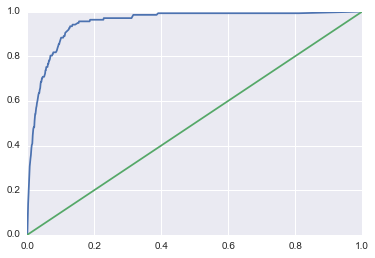

In [298]:
fpr, tpr, thresholds = metrics.roc_curve(y_all, forest.predict_proba(X_all)[:,1])
plt.plot(fpr, tpr,
         fpr, fpr) # Second x,y pairs here are just to plot a line with slop 1.
